In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
from tensorflow import keras
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers,models, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
from tensorflow.keras.applications import ResNet50, MobileNetV3Small
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.layers import Lambda
from pathlib import Path
import glob
import os
import cv2

tf.get_logger().setLevel('INFO')


In [2]:
if not tf.test.gpu_device_name():
    print('No GPU found')
else:
    print('Default GPU device: {}' .format(tf.test.gpu_device_name()))

Default GPU device: /device:GPU:0


In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)


    return images

In [4]:
def data(folders):
    imgs = []
    labels = []
    names = []
    for folder in folders:
        for img in load_images_from_folder(folder):
            imgs.append(img)

            if 'CaS' in folder:
                labels.append('CaS')
            elif 'CoS' in folder:
                labels.append('CoS')
            elif 'Gum' in folder:
                labels.append('Gum')
            elif 'MC' in folder:
                labels.append('MC')
            elif 'OC' in folder:
                labels.append('OC')
            elif 'OLP' in folder:
                labels.append('OLP')
            elif 'OT' in folder:
                labels.append('OT')
            else:
                print("error")

        for name in os.listdir(folder):
            names.append(os.path.join(folder, name))

    names = pd.Series(names, name= 'name')
    imgs = pd.Series(imgs, name='image', dtype= np.float32)
    labels = pd.Series(labels, name="label")

    image_df = pd.concat([names, imgs, labels], axis=1)

    return image_df


In [5]:
path = "Teeth project/Teeth_Dataset/Training"
folders = [os.path.join(path, x) for x in os.listdir(path)]
train_df = data(folders)

In [6]:
path = "Teeth project/Teeth_Dataset/Testing"
folders = [os.path.join(path, x) for x in os.listdir(path)]
test_df = data(folders)

In [7]:
path = "Teeth project/Teeth_Dataset/Validation"
folders = [os.path.join(path, x) for x in os.listdir(path)]
validation_df = data(folders)

# Visulaization

In [8]:
label_counts = train_df["label"].value_counts()

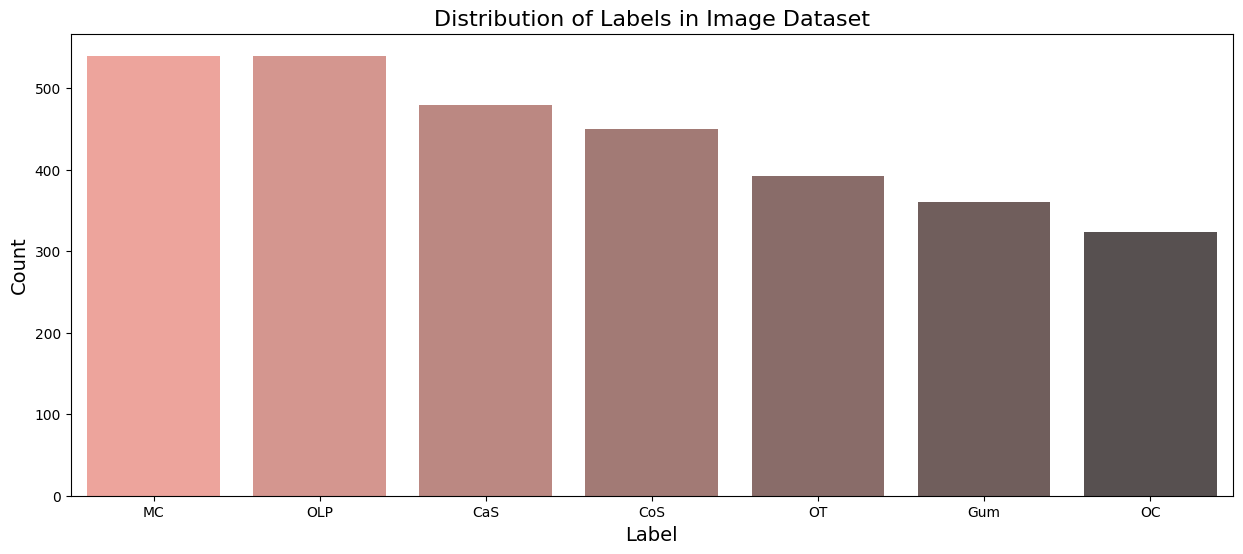

In [9]:
plt.figure(figsize=(15, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')

plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

<Figure size 2000x1000 with 0 Axes>

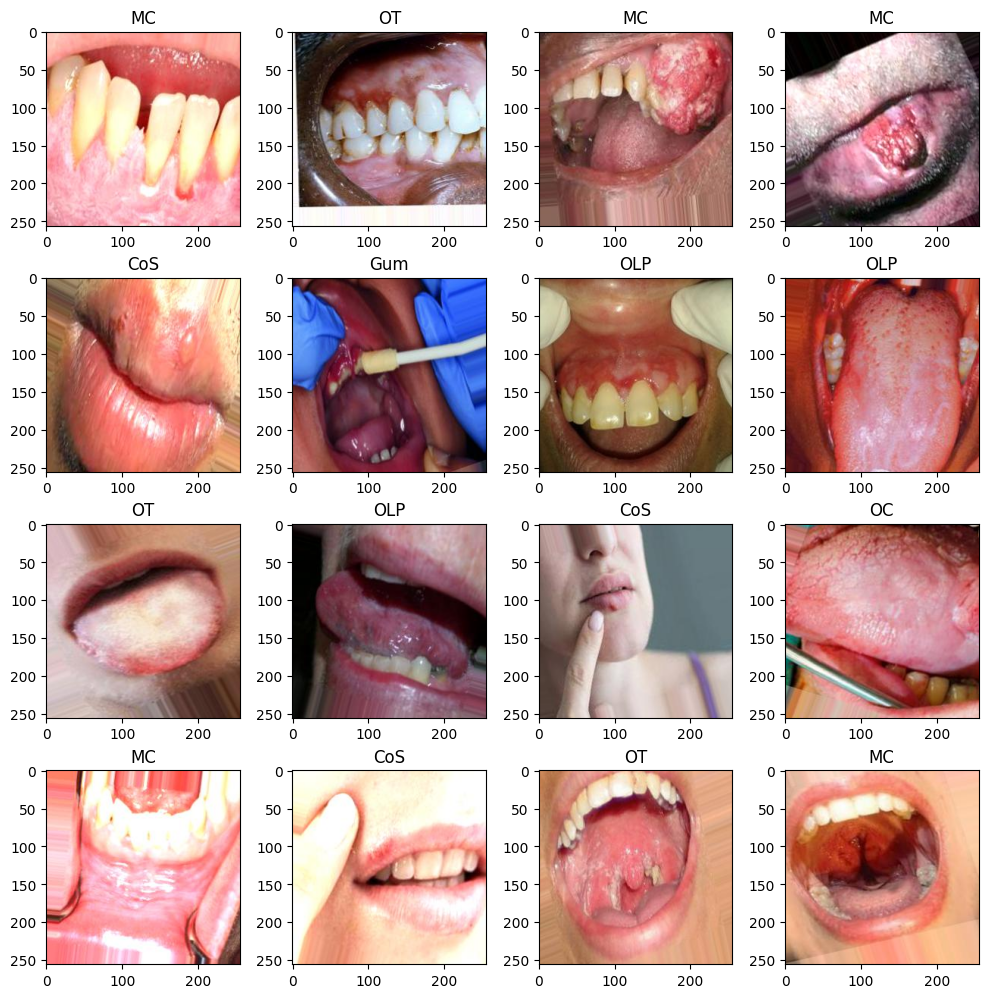

In [10]:
plt.figure(figsize= (20, 10))
random_values = np.random.randint(0, len(train_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize = (10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.name[random_values[i]]))
    ax.set_title(train_df.label[random_values[i]])
    plt.tight_layout()
plt.show()

# PreProcessing

In [11]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [12]:
train_path = train_df.pop("name").astype(str)
valid_path = validation_df.pop("name").astype(str)
train_path = test_df.pop("name").astype(str)



In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_directory(
    "Teeth project/Teeth_Dataset/Training",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = train_datagen.flow_from_directory(
    "Teeth project/Teeth_Dataset/Validation",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen_generator = train_datagen.flow_from_directory(
    "Teeth project/Teeth_Dataset/Testing",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


# Training From Scratch

In [ ]:
# input_shape = [224, 224, 3]

# model = tf.keras.Sequential([

#     layers.Conv2D(filters= 64, kernel_size= (3,3), activation= "relu", input_shape= input_shape ),
#     layers.MaxPool2D(pool_size=(2,2), strides= 2),
#     layers.Conv2D(filters= 128, kernel_size= (3,3), activation= "relu", input_shape= input_shape ),
#     layers.MaxPool2D(pool_size=(2,2), strides= 2),
#     layers.Conv2D(filters= 256, kernel_size= (3,3), activation= "relu", input_shape= input_shape ),
#     layers.MaxPool2D(pool_size=(2,2), strides= 2),

#     layers.Flatten(),
#     layers.Dense(units= 1000, activation= "relu"),
#     layers.Dropout(.5),
#     layers.Dense(units= 200, activation= "relu"),


#     layers.Dense(7, activation= "softmax")


# ])

# model.summary()

# model.compile(
#     optimizer= keras.optimizers.Adamax(learning_rate=.0001),
#     loss = "categorical_crossentropy",
#     metrics= ["accuracy"]
# )

In [14]:
# # Create checkpoint callback
# checkpoint_path = "model_checkpoint.keras"
# checkpoint_callback = ModelCheckpoint(checkpoint_path,
#                                       monitor="val_accuracy",
#                                       save_best_only=True)

# # Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
#                                patience = 10,
#                                restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Transfer Learning

In [ ]:
# input_shape = [224, 224, 3]
# mob_net = MobileNetV2(input_shape= input_shape, include_top= False, classes=1000, pooling= "max", )
# mob_net.summary()

In [ ]:
# model_without_last_layer = tf.keras.Model(inputs=mob_net.input, outputs=mob_net.layers[-2].output)
# model_without_last_layer.summary()

In [ ]:
# for lay in model_without_last_layer.layers:
#     lay.trainable = False

In [ ]:
# # Create checkpoint callback
# checkpoint_path = "MobileNet.keras"
# checkpoint_callback = ModelCheckpoint(checkpoint_path,
#                                       monitor="val_accuracy",
#                                       save_best_only=True)

# # Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
#                                patience = 10,
#                                restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-10)

In [17]:
# model = Sequential()
# model.add(Lambda(lambda x: x, input_shape=(224, 224, 3)))

# model.add(model_without_last_layer)

# model.add(Conv2D(750, (3, 3), activation= "relu", padding= "same"))
# model.add(tf.keras.layers.SpatialDropout2D(.5))
# model.add(Conv2D(350, (3, 3), activation= "relu", padding= "same"))
# model.add(tf.keras.layers.SpatialDropout2D(.5))

# model.add(Conv2D(100, (3, 3), activation= "relu"))
# model.add(tf.keras.layers.SpatialDropout2D(.5))

# model.add(Flatten())

# model.add(Dense(250, activation= "relu"))
# model.add(layers.Dropout(.5))
# model.add(Dense(100, activation= "relu"))
# model.add(layers.Dropout(.5))

# model.add(Dense(7, activation= "softmax"))

# model.summary()

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:G

In [ ]:
# model.compile(
#     optimizer= keras.optimizers.Adam(learning_rate=.0001),
#     loss = "categorical_crossentropy",
#     metrics= ["accuracy"]
# )

In [ ]:
# model = keras.models.load_model("teeth_classification.hdf5")
# model.compile(
#     optimizer= keras.optimizers.Adamax(learning_rate=.0001),
#     loss = "categorical_crossentropy",
#     metrics= ["accuracy"]
# )


In [ ]:
# history = model.fit(
#     train_generator,
#     epochs=150,
#     validation_data= valid_generator,
#     callbacks=[
#         early_stopping,
#         reduce_lr, 
#         checkpoint_callback
#     ]
#  )

In [14]:
model = keras.models.load_model("teeth_classification.h5")
# model.compile(
#     optimizer= keras.optimizers.Adamax(learning_rate=.0001),
#     loss = "categorical_crossentropy",
#     metrics= ["accuracy"]
# )


# history = model.fit(
#     train_generator,
#     epochs=40,
#     validation_data= valid_generator,
#     callbacks=[
#         early_stopping,
#         reduce_lr, 
#         checkpoint_callback
#     ]
#  )

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executin

In [15]:
results = model.evaluate(test_datagen_generator , verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp i

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
keras.models.save_model(model, "C:/Users/Mourad/Desktop/teeth_classification.h5")

In [ ]:
model.save_weights("weights.h5")

In [5]:
# import gdown
# import tensorflow as tf

# # Google Drive file ID
# # file_id = '1H0XT5rozo8HUeUXNV3t7I1q27I7eh4Q2'  # Replace with your actual Google Drive file ID
# # https://drive.google.com/file/d/1XWMLwWfxcqk5S45ni7rF1S4K9JYo7xJf/view?usp=drive_link
# # Create the download URL

# url = 'https://drive.google.com/uc?id=1XWMLwWfxcqk5S45ni7rF1S4K9JYo7xJf'

# # Download the file using gdown
# output = 'teeth_classification.h5'
# gdown.download(id="1XWMLwWfxcqk5S45ni7rF1S4K9JYo7xJf" , quiet=False)

# # Load the model
# model = tf.keras.models.load_model('model.h5')




# import urllib.request
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# # Step 3: Download the weights file
# weights_url = 'https://drive.google.com/uc?id=1XWMLwWfxcqk5S45ni7rF1S4K9JYo7xJf'  # Replace with your actual URL
# weights_path = 'model_weights.h5'
# urllib.request.urlretrieve(weights_url, weights_path)

# # Step 4: Load the weights into the model
# model.load_weights(weights_path)

FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1XWMLwWfxcqk5S45ni7rF1S4K9JYo7xJf

but Gdown can't. Please check connections and permissions.

# TRASH

In [ ]:
# path = "Teeth_Dataset/Training/"
# labels = os.listdir(path)
# folders = [os.path.join(path, x) for x in os.listdir(path)]

# print(labels)

# all_images = [img for folder in folders for img in load_images_from_folder(folder)]
# all_labels = [lab for folder in folders for lab in load_labels_from_folder(folder)]



In [ ]:
# train_batch = datagen.flow_from_dataframe(
#     dataframe = train_df,
#     x_col = 'image',
#     y_col = 'label',
#     target_size = TARGET_SIZE,
#     class_mode='categorical',
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     seed= 42,
#     subset='training',

# )

# valid_batch = generator.flow_from_dataframe(
#     dataframe = validation_df,
#     x_col = 'image',
#     y_col = 'label',
#     target_size = TARGET_SIZE,
#     class_mode='categorical',
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     seed= 42,
#     subset='training'
# )

# test_batch = generator.flow_from_dataframe(
#     dataframe = test_df,
#     x_col = 'image',
#     y_col = 'label',
#     target_size = TARGET_SIZE,
#     class_mode='categorical',
#     batch_size=BATCH_SIZE,
#     shuffle= False,
#     subset='training'
# )





# train_generator = train_datagen.flow_from_directory(
#     "/content/Teeth_Dataset/Training",
#     target_size=TARGET_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='categorical'
# )

# val_generator = val_datagen.flow_from_directory(
#     "/content/Teeth_Dataset/Validation",
#     target_size=TARGET_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='categorical'
# )

# test_generator = test_datagen.flow_from_directory(
#     "/content/Teeth_Dataset/Testing",
#     target_size=TARGET_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='categorical'
# )

In [ ]:
# train_size = len(train_dataset)
# validation_size = len(validation_dataset)

# train_steps = int(len(train_dataset) / BATCH_SIZE)
# validation_steps = int(len(validation_dataset) /  BATCH_SIZE)


In [ ]:
# augment = tf.keras.Sequential([
#   layers.Resizing(224,224, 3),
#   layers.Rescaling(1./255),
#   layers.RandomFlip("horizontal"),
#   layers.RandomRotation(0.1),
#   layers.RandomZoom(0.1),
#   layers.RandomContrast(0.1)
# ])



In [ ]:
# history = model.fit(
#     train_generator,
#     steps_per_epoch=len(train_generator),
#     validation_data=valid_generator ,
#     validation_steps=len(valid_generator),
#     epochs=100,
#     callbacks=[
#         early_stopping,
#         keras.callbacks.TensorBoard("training_logs", 
#                                     "bird_classification"),
#         checkpoint_callback,
#         reduce_lr
#     ]
# )